In [2]:
import pandas as pd
import numpy as np
from cv_py import CrossValidation
from dataloading import DataLoader
from eda_py import EDA
from visualize_py import Visualize
import seaborn as sns
import matplotlib.pyplot as plt
from implicit.evaluation import train_test_split
from eals import ElementwiseAlternatingLeastSquares, load_model

In [3]:
%cd C:\Users\781110104\OneDrive - Genpact\Documents\VSCode

C:\Users\781110104\OneDrive - Genpact\Documents\VSCode


In [4]:
dl = DataLoader()
user_item_co_t = dl.import_data('TEREX', 'CO', 'df', clip=99.999)
user_item_po_t = dl.import_data('TEREX', 'PO', 'df', clip=99.999)
user_item_co_a = dl.import_data('AGCO', 'CO', 'df', clip=99.999)
user_item_po_a = dl.import_data('AGCO', 'PO', 'df', clip=99.999)

In [68]:
eda = EDA()

In [72]:
eda.get_basic_user_item_info(user_item_co_a, user_item_co_t)

,nouser,noitem,nnz,sparsity
co,292,258398,1822377,0.975847
po,39,43236,71040,0.957870


In [73]:
eda.get_user_per_item_frame(user_item_co_a, user_item_co_t)

,count,mean,std,min,25%,50%,75%,max
podl_upi,43236.0,1.643075,1.509110,1.0,1.0,1.0,2.00,18.0
codl_upi,258398.0,7.052597,15.156893,1.0,1.0,2.0,6.00,287.0
podl_ipu,39.0,1821.538462,3441.804880,130.0,606.5,812.0,1451.00,20842.0
codl_ipu,292.0,6241.017123,7470.930569,173.0,2229.5,4219.5,7203.25,52207.0


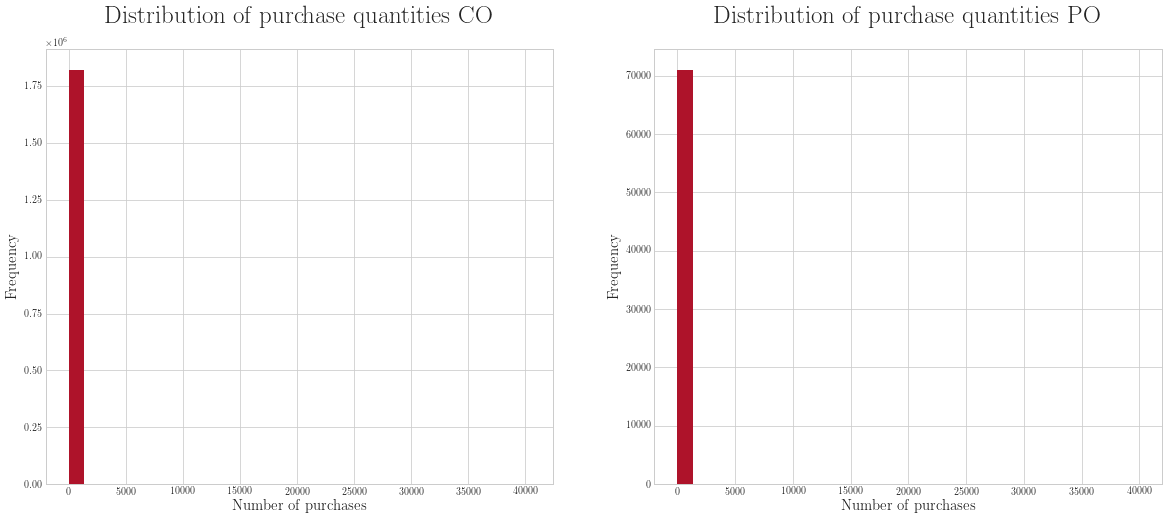

In [74]:
eda.get_purchase_histograms('AGCO', user_item_co_a, user_item_co_t)

In [76]:
user_item_co_t.purchases.describe()

count    71040.000000
mean        18.804444
std        280.790525
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      39931.102390
Name: purchases, dtype: float64

In [77]:
user_item_co_a.purchases.describe()

count    1.822377e+06
mean     1.268708e+01
std      2.022613e+02
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      4.041369e+04
Name: purchases, dtype: float64

In [5]:
user_item_csr_t = dl.to_csr(user_item_co_t)
user_item_csr_a = dl.to_csr(user_item_co_a)

In [9]:
train, test = train_test_split(user_item_csr_t, train_percentage=0.9)

In [18]:
cv = CrossValidation(dl.to_csr(user_item_co_t), 5)

In [19]:
test_k, train_k = cv.split_k_fold()

In [6]:
cv_t = CrossValidation(user_item_csr_t, 5)
cv_a = CrossValidation(user_item_csr_a, 5)

In [7]:
test_t, train_t = cv_t.split_k_fold()
test_a, train_a = cv_a.split_k_fold()

In [9]:
alpha = (user_item_csr.shape[0] * user_item_csr.shape[1] - user_item_csr.nnz) / sum(user_item_csr.data)

In [10]:
alpha

1.0920634173446777

In [177]:
train1 = train_k['0']
train2 = train_k['1']
train3 = train_k['2']
train4 = train_k['3']
train5 = train_k['4']

test1 = test_k['0']
test2 = test_k['1']
test3 = test_k['2']
test4 = test_k['3']
test5 = test_k['4']

In [11]:
import implicit

In [178]:
import implicit


model1 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model2 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model3 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model4 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model5 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)

In [179]:
model1.fit(train1)
model2.fit(train2)
model3.fit(train3)
model4.fit(train4)
model5.fit(train5)

100%|██████████| 15/15 [00:00<00:00, 25.72it/s]


In [202]:
test2.nnz

14170

In [12]:
model1 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)

In [14]:
model1.fit(train)

100%|██████████| 15/15 [00:00<00:00, 22.18it/s]


In [15]:
implicit.evaluation.ranking_metrics_at_k(model1, train, test, 10)

100%|██████████| 39/39 [00:00<00:00, 2443.90it/s]


{'precision': 0.34615384615384615,
 'map': 0.24768925518925514,
 'ndcg': 0.37836888199185437,
 'auc': 0.516789394924753}

In [203]:
ev1 = implicit.evaluation.ranking_metrics_at_k(model1, train1, test1, K=test1.nnz)
ev2 = implicit.evaluation.ranking_metrics_at_k(model2, train2, test2, K=test2.nnz)
ev3 = implicit.evaluation.ranking_metrics_at_k(model3, train3, test3, K=test3.nnz)
ev4 = implicit.evaluation.ranking_metrics_at_k(model4, train4, test4, K=test4.nnz)
ev5 = implicit.evaluation.ranking_metrics_at_k(model5, train5, test5, K=test5.nnz)

100%|██████████| 39/39 [00:00<00:00, 240.68it/s]


In [204]:
pd.DataFrame([ev1, ev2, ev3, ev4, ev4]).mean()

precision    0.513414
map          0.118798
ndcg         0.527931
auc          0.798878
dtype: float64

In [30]:
space_iALS_t = {'factors' : [64], 'regularization' : [0.01], 'alpha' : [0.05], 'iterations' : [15]}
hyper_test_als_t = cv_t.hyperp_tuning(test_t, train_t, space_iALS, 'iALS')

{'factors': 64, 'regularization': 0.01, 'alpha': 0.5, 'iterations': 15}


In [176]:
hyper_test_als_t

,factors,regularization,alpha,iterations,precision,map,ndcg,auc,mpr
0,64,20,0.3,15,0.516923,0.404485,0.543912,0.5141,0.184817


In [168]:
hyper_test_als = pd.concat((hyper_test_als, hyper_test_als_t), axis=0)

In [26]:
space_iALS

{'factors': [64],
 'regularization': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70],
 'alpha': [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 30],
 'iterations': [15]}

In [8]:
space_iALS = {'factors' : [64], 'regularization' : [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70], 'alpha' : [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 5, 10, 15, 20, 30], 'iterations' : [15]}
hyper_als_t = cv_t.hyperp_tuning(test_t, train_t, space_iALS, 'iALS')
hyper_als_a = cv_a.hyperp_tuning(test_a, train_a, space_iALS, 'iALS')


c:\Users\781110104\Anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


In [11]:
hyper_als_t.to_csv('terex_ials.csv')
hyper_als_a.to_csv('agco_ials.csv')

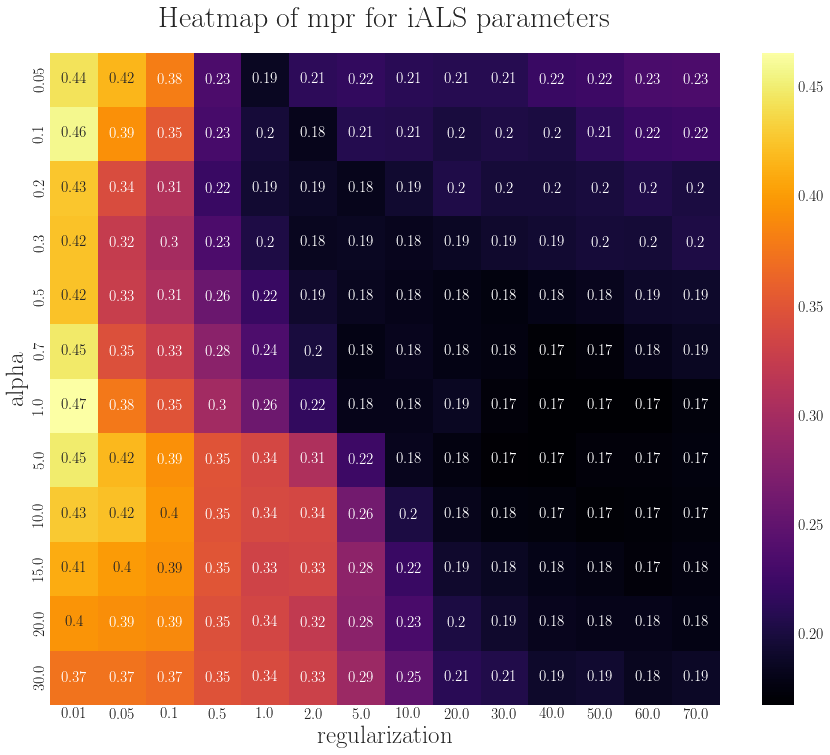

In [57]:
vis = Visualize()
vis.get_heatmap(hyper_als_t, 'iALS', 'mpr')

In [9]:
space_BPR = {'factors' : [64], 'learning_rate': [0.001, 0.0025, 0.005, 0.01, 0.02, 0.03, 0.07, 0.1, 0.2, 0.3], 'regularization' : [0.001, 0.005, 0.01, 0.03, 0.07, 0.1, 0.15, 0.2, 0.3], 'iterations' : [100]}
hyper_bpr_t = cv_t.hyperp_tuning(test_t, train_t, space_BPR, 'BPR')
hyper_bpr_a = cv_a.hyperp_tuning(test_a, train_a, space_BPR, 'BPR')

{'factors': 64, 'learning_rate': 0.001, 'regularization': 0.001, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.001, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.001, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.001, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.001, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.001, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.005, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.005, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.005, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.005, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.005, 'iterations': 100}
{'factors': 64, 'learning_rate': 0.3, 'regularization': 0.01, 'iterations': 100}
{'factors': 64,

In [12]:
hyper_bpr_t.to_csv('terex_bpr.csv')
hyper_bpr_a.to_csv('agco_bpr.csv')

In [29]:
hyper_bpr_t

,factors,learning_rate,regularization,iterations,precision,map,ndcg,auc,mpr
0,64,0.001,0.001,100,0.217436,0.150565,0.235400,0.504306,0.227226
1,64,0.001,0.005,100,0.139487,0.097455,0.150250,0.501714,0.286475
2,64,0.001,0.010,100,0.087692,0.054478,0.094387,0.501171,0.319960
3,64,0.001,0.030,100,0.084103,0.046569,0.083191,0.501133,0.327750
4,64,0.001,0.070,100,0.084615,0.048943,0.086506,0.501140,0.330434
...,...,...,...,...,...,...,...,...,...
85,64,0.300,0.070,100,0.148718,0.065256,0.150370,0.503888,0.111967
86,64,0.300,0.100,100,0.077949,0.029378,0.075674,0.501674,0.119689
87,64,0.300,0.150,100,0.061026,0.019865,0.058373,0.501139,0.134512
88,64,0.300,0.200,100,0.044615,0.016447,0.045283,0.500807,0.153840


In [44]:
vis = Visualize()
vis.get_heatmap(hyper_bpr_t, 'BPR', 'precision')

RuntimeError: latex was not able to process the following string:
b'learning_rate'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6730)
entering extended mode
(C:/Users/781110104/.matplotlib/tex.cache/f0885d253df0b09261f26ef266406228.tex
LaTeX2e <2018-04-01> patch level 5

(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\arti
cle.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class

(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\size
10.clo))
(C:\Users\781110104\AppData\Roaming\MiKTeX\2.9\tex\latex\type1cm\type1cm.sty)
(C:\Users\781110104\AppData\Roaming\MiKTeX\2.9\tex\latex\cm-super\type1ec.sty
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\t1cm
r.fd))
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\inpu
tenc.sty)
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\geometry\
geometry.sty
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\graphics\
keyval.sty)
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\generic\oberdie
k\ifpdf.sty)
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\generic\oberdie
k\ifvtex.sty)
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\generic\ifxetex
\ifxetex.sty)
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\geometry\
geometry.cfg))
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\text
comp.sty
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\ts1e
nc.def
(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\ts1e
nc.dfu)))
No file f0885d253df0b09261f26ef266406228.aux.

(c:\Users\781110104\Anaconda3\Library\miktex\texmfs\install\tex\latex\base\ts1c
mr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily learning_
                         rate}
No pages of output.
Transcript written on f0885d253df0b09261f26ef266406228.log.




<Figure size 1080x864 with 2 Axes>

In [64]:
ind = 'learning_rate'
col = 'regularization'
metric = 'precision'
heatmap_df = hyper_bpr_t.pivot(index=ind, columns=col, values=metric)
heatmap_df

regularization,0.001,0.005,0.010,0.030,0.070,0.100,0.150,0.200,0.300
learning_rate,,,,,,,,,
0.0010,0.217436,0.139487,0.087692,0.084103,0.084615,0.088718,0.087692,0.095385,0.094359
0.0025,0.243590,0.251795,0.250769,0.225641,0.103590,0.109744,0.103077,0.110769,0.104615
0.0050,0.307692,0.350256,0.364103,0.398462,0.245641,0.112821,0.095897,0.113333,0.101026
0.0100,0.231795,0.315897,0.336923,0.362564,0.386667,0.380000,0.099487,0.097949,0.091282
0.0200,0.173333,0.272308,0.300513,0.338974,0.324103,0.321538,0.309744,0.194872,0.073846
0.0300,0.136410,0.224103,0.270256,0.298462,0.302564,0.283077,0.281538,0.215897,0.068718
0.0700,0.101026,0.163077,0.186667,0.230256,0.210256,0.188718,0.184615,0.171795,0.112308
0.1000,0.102051,0.148205,0.170256,0.208718,0.157436,0.155385,0.139487,0.136923,0.086154
0.2000,0.094359,0.160000,0.220000,0.219487,0.141026,0.100513,0.089231,0.088205,0.051795


In [10]:
space_eALS = {'factors' : [64], 'alpha': [0.25, 0.5, 0.75, 1], 'regularization':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'w0':[2, 5, 10, 15, 20, 30, 50]}
hyper_eals_t = cv_t.hyperp_tuning(test_t, train_t, space_eALS, 'eALS')
hyper_eals_a = cv_a.hyperp_tuning(test_a, train_a, space_eALS, 'eALS')

converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items t

In [13]:
hyper_eals_t.to_csv('terex_eals.csv')
hyper_eals_a.to_csv('agco_eals.csv')

In [ ]:
space_LMF = {'factors' : [64], 'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5], 'regularization' : [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5], 'iterations' : [35], 'neg_prop' : [5, 10, 20, 30]}
hyper_lmf_t = cv_t.hyperp_tuning(test_t, train_t, space_LMF, 'LMF')
hyper_lmf_a = cv_a.hyperp_tuning(test_a, train_a, space_LMF, 'LMF')

{'factors': 64, 'learning_rate': 0.001, 'regularization': 0, 'iterations': 35, 'neg_prop': 30}


In [12]:
space_eALS = {'factors' : [64], 'alpha': [0.25], 'regularization':[0.001], 'w0':[5]}
test_cv_eals = cv.hyperp_tuning(test_k, train_k, space_eALS, 'eALS')

converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>


In [15]:
space_eALS = {'factors' : [64], 'alpha': [0.25, 0.5, 0.75], 'regularization':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5], 'w0':[5, 10, 20, 30]}
test_cv_eals = cv.hyperp_tuning(test_k, train_k, space_eALS, 'eALS')

converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items t

In [23]:
hyper_test_lmf = pd.concat((hyper_test_lmf, hyper_test_lmf_add), axis=0)

In [16]:
hyper_test_als.to_csv('als_tuning.csv')
hyper_test_bpr.to_csv('bpr_tuning.csv')
pd.concat((hyper_test_lmf, hyper_test_lmf_add), axis=0).to_csv('lmf_tuning.csv')
test_cv_eals.to_csv('eals_tuning.csv')

In [17]:
vis = Visualize()

In [28]:
hyper_test_lmf[hyper_test_lmf.neg_prop == 5]

,factors,learning_rate,regularization,iterations,neg_prop,precision,map,ndcg,auc,mpr
0,64,0.001,0.000,35,5,0.001538,0.000621,0.001795,0.499932,0.485535
3,64,0.001,0.001,35,5,0.003590,0.001172,0.003786,0.499923,0.487481
6,64,0.001,0.005,35,5,0.005641,0.001719,0.005796,0.500037,0.487931
9,64,0.001,0.010,35,5,0.005641,0.002189,0.006575,0.500040,0.484803
12,64,0.001,0.050,35,5,0.004103,0.001606,0.004754,0.499944,0.489764
...,...,...,...,...,...,...,...,...,...,...
225,64,5.000,0.100,35,5,0.047179,0.020244,0.054745,0.501305,0.442749
228,64,5.000,0.500,35,5,0.055897,0.020621,0.057439,0.501260,0.450649
231,64,5.000,1.000,35,5,0.064615,0.028116,0.072415,0.501701,0.453801
234,64,5.000,2.000,35,5,0.065128,0.024665,0.067423,0.501724,0.448467


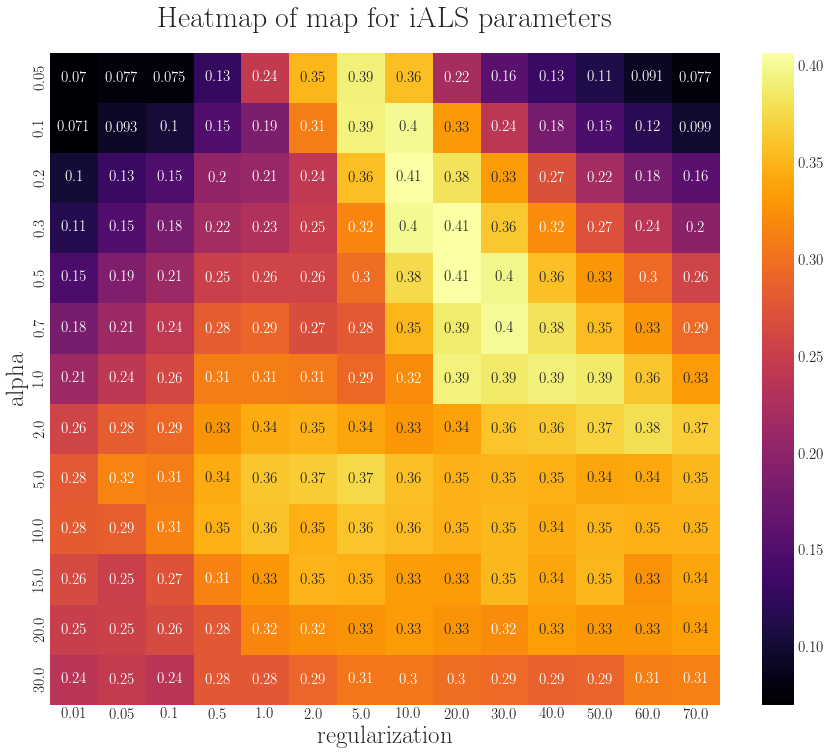

In [174]:
vis.get_heatmap(hyper_test_als, 'iALS', 'map')